# Pre-Snap Game Prediction!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.datasets import make_classification 
import xgboost as xgb

# Function to drop unwanted features from the dataset
def drop_unwanted_features(df, features_to_drop):
    """
    Drops specified features (columns) from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features_to_drop (list): List of column names to drop.
    
    Returns:
    pd.DataFrame: A new DataFrame with the specified columns dropped.
    """
    # Check if all columns to drop exist in the DataFrame
    features_to_drop = [feature for feature in features_to_drop if feature in df.columns]
    
    # Drop the unwanted features
    df_cleaned = df.drop(columns=features_to_drop)
    
    return df_cleaned
    # Returns a DataFrame without the unwanted columns

# Function to convert game clock time into seconds
def convert_to_seconds(game_clock):
    """
    Converts the game clock time (in 'MM:SS' format) to seconds.
    
    Parameters:
    game_clock (str): The game clock time as a string in 'MM:SS' format.
    
    Returns:
    int: The game clock time converted into seconds.
    """
    # Split the clock string into minutes and seconds and convert to integers
    minutes, seconds = map(int, game_clock.split(':'))
    
    # Convert the time into total seconds
    return minutes * 60 + seconds

# Function to calculate remaining time till the end of the half
def calculate_remaining_time_end_of_half(row):
    """
    Calculates the remaining time in seconds until the end of the half based on the game clock and half number.
    
    Parameters:
    row (pd.Series): A row of the DataFrame containing 'gameClock' and 'half' columns.
    
    Returns:
    int: The remaining time in seconds until the end of the half.
    """
    half_game_time = 30 * 60  # 1800 seconds in a half (30 minutes * 60 seconds)
    
    # Convert the game clock to seconds for the current row
    quarter_time_remaining = convert_to_seconds(row['gameClock'])
    
    # Calculate the total elapsed time in the game up to the current quarter
    # Half 1 includes the first two quarters (each 15 minutes or 900 seconds), so we account for that
    elapsed_time = (row['half'] - 1) * 900 + (900 - quarter_time_remaining)
    
    # Remaining time until the end of the half
    return half_game_time - elapsed_time


### Initial Data Understanding and Cleaning

In [3]:
plays_df = pd.read_csv(r'C:\Users\Karahan C\Desktop\Portfolio Projects\Kaggle\nfl-big-data-bowl-2025\plays.csv')
games_df = pd.read_csv(r'C:\Users\Karahan C\Desktop\Portfolio Projects\Kaggle\nfl-big-data-bowl-2025\games.csv')


In [4]:
plays_df.sample(5)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
2991,2022103001,4042,(:03) M.Mariota kneels to ATL 24 for -1 yards.,4,2,10,ATL,CAR,ATL,25,...,-1,0.177876,-0.177876,0.000000,False,UNDEFINED,NaN,0,NaN,NaN
10075,2022100300,3882,(:45) (Shotgun) M.Stafford pass short left to ...,4,1,10,LA,SF,LA,42,...,9,-0.000912,0.000912,0.139395,True,NaN,NaN,0,Quarters,Zone
11040,2022092504,2074,(:14) (Shotgun) K.Cousins pass short middle to...,2,2,10,MIN,DET,MIN,44,...,12,-0.007676,0.007676,-0.046069,True,NaN,NaN,0,Cover-1,Man
1545,2022100911,2708,(7:08) (Shotgun) D.Williams up the middle to A...,3,2,5,ARI,PHI,ARI,40,...,2,-0.022756,0.022756,-0.775662,False,INSIDE ZONE,NaN,1,Cover-3,Zone
5253,2022091101,2478,(10:23) M.Dunn reported in as eligible. N.Chu...,3,1,10,CLE,CAR,CAR,35,...,20,-0.005040,0.005040,1.151179,False,POWER,NaN,0,Cover-3,Zone


As we see this dataframe contains various data about plays as descriptive, post-snap or pre-snap. Since we investigate a pre-snap incident we could drop irrelevant features like playDescription.   

In [5]:
plays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            16124 non-null  int64  
 1   playId                            16124 non-null  int64  
 2   playDescription                   16124 non-null  object 
 3   quarter                           16124 non-null  int64  
 4   down                              16124 non-null  int64  
 5   yardsToGo                         16124 non-null  int64  
 6   possessionTeam                    16124 non-null  object 
 7   defensiveTeam                     16124 non-null  object 
 8   yardlineSide                      15900 non-null  object 
 9   yardlineNumber                    16124 non-null  int64  
 10  gameClock                         16124 non-null  object 
 11  preSnapHomeScore                  16124 non-null  int64  
 12  preS

In [6]:
games_df.sample(5)

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
16,2022091500,2022,2,9/15/2022,20:15:00,KC,LAC,27,24
83,2022101602,2022,6,10/16/2022,13:00:00,GB,NYJ,10,27
6,2022091105,2022,1,9/11/2022,13:00:00,HOU,IND,20,20
65,2022100900,2022,5,10/9/2022,9:30:00,GB,NYG,22,27
86,2022101605,2022,6,10/16/2022,13:00:00,NO,CIN,26,30


In [7]:
plays_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [8]:
games_df.columns

Index(['gameId', 'season', 'week', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore',
       'visitorFinalScore'],
      dtype='object')

In [9]:
df = plays_df.merge(games_df[['gameId','homeTeamAbbr', 'visitorTeamAbbr']], on='gameId', how='left')
# Merged two data set on gameIds

I've merged the two data-set for is possesion team whether leading or not

In [10]:
df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [11]:
features_to_drop = ['gameId','playId','isDropback', 'expectedPointsAdded', 'yardsGained', 'visitorTeamWinProbilityAdded',
                    'homeTeamWinProbabilityAdded','prePenaltyYardsGained','penaltyYards','rushLocationType','qbSneak',
                    'qbKneel','qbSpike','unblockedPressure','passTippedAtLine','timeToSack','timeInTackleBox','timeToThrow',
                    'passLocationType','dropbackDistance','dropbackType','playAction','targetX', 'targetY','passLength',
                    'playClockAtSnap', 'expectedPoints','preSnapVisitorTeamWinProbability','preSnapHomeTeamWinProbability',
                    'playNullifiedByPenalty','yardlineSide','yardlineNumber','playDescription','pff_manZone','pff_passCoverage',
                    'pff_runPassOption','pff_runConceptSecondary','pff_runConceptPrimary']
 

In here I've droped unnecessary columns for prediction

In [12]:
df_cleaned = drop_unwanted_features(df,features_to_drop)


In [13]:
df_cleaned.sample(5)

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,receiverAlignment,passResult,homeTeamAbbr,visitorTeamAbbr
5480,4,2,10,GB,NYG,06:01,20,27,85,SHOTGUN,2x2,NaN,GB,NYG
11412,3,3,11,TEN,LV,04:55,24,13,86,SHOTGUN,2x2,IN,TEN,LV
4730,3,3,3,ATL,LAC,03:48,10,14,107,SHOTGUN,2x2,NaN,ATL,LAC
8248,2,1,10,GB,TB,00:41,3,14,37,SHOTGUN,3x1,C,TB,GB
14521,2,3,5,DET,PHI,05:20,7,21,40,SHOTGUN,3x1,C,DET,PHI


In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   quarter                 16124 non-null  int64 
 1   down                    16124 non-null  int64 
 2   yardsToGo               16124 non-null  int64 
 3   possessionTeam          16124 non-null  object
 4   defensiveTeam           16124 non-null  object
 5   gameClock               16124 non-null  object
 6   preSnapHomeScore        16124 non-null  int64 
 7   preSnapVisitorScore     16124 non-null  int64 
 8   absoluteYardlineNumber  16124 non-null  int64 
 9   offenseFormation        15936 non-null  object
 10  receiverAlignment       15936 non-null  object
 11  passResult              9736 non-null   object
 12  homeTeamAbbr            16124 non-null  object
 13  visitorTeamAbbr         16124 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


## Feature Creation

I have tried to create my features in scope of situational football:
- Is my team behind? I would tend to play because I would tie the fame asap.
- Is my team needs to hurry for a TD because we are behind and run out of time?
- Are we leading and inside last two mins? I would tend to run the ball because I gotta melt time.  

In [15]:
# Half feature created 
df_cleaned['half'] = df_cleaned['quarter'].apply(lambda row: 1 if row < 3 else 2)

In [16]:
# Remaing time feature created
df_cleaned.loc[:, 'remainingTime'] = df_cleaned.apply(calculate_remaining_time_end_of_half, axis=1)


In [17]:
# df_cleaned dataset score data store as preSnapHomeScore and preSnapVisitor but team stored as possesionTeam and defensiveTeam.    

df_cleaned['possessionTeamScore'] = df_cleaned.apply(lambda row: row['preSnapHomeScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
  
df_cleaned['defensiveTeamScore'] = df_cleaned.apply(lambda row: row['preSnapVisitorScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapHomeScore'], axis=1)

# So I converted preSnapHomeScore and preSnapVisitor data to possessionTeamScore and defensiveTeamScore.

In [18]:
# This feature shows how many yards left for TD
df_cleaned['yardsToTd'] = df_cleaned['absoluteYardlineNumber'] - 10

In [19]:
# This feature creates a score difference and shows that possesion team leading or not.  
df_cleaned['possessionTeamLeadsBy'] = df_cleaned['possessionTeamScore'] - df_cleaned['defensiveTeamScore']

In [20]:
df_cleaned['isPossessionTeamLead'] = df_cleaned.apply(lambda row: 0 if row['possessionTeamLeadsBy'] > 0 else 1, axis=1 )
df_cleaned['isPossessionTeamLead'] = df_cleaned['isPossessionTeamLead'].astype('byte')

In [21]:
# Get the list of column names
new_order = ['half','quarter', 'gameClock','remainingTime', 'down', 'yardsToGo', 'yardsToTd','possessionTeamLeadsBy','isPossessionTeamLead',
             'possessionTeam', 'defensiveTeam','homeTeamAbbr', 'visitorTeamAbbr','possessionTeamScore', 'defensiveTeamScore',
             'preSnapHomeScore','preSnapVisitorScore', 'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment', 'passResult']

# Reorder the columns in the DataFrame
df_cleaned = df_cleaned[new_order]

# Check the reordered DataFrame
print(df_cleaned.head())


   half  quarter gameClock  remainingTime  down  yardsToGo  yardsToTd  \
0     2        3     01:54            114     1         10         21   
1     2        4     02:13            133     1         10          8   
2     2        4     02:00            120     3         12         20   
3     1        1     09:28           1468     2         10         23   
4     2        3     02:16            136     2          8         27   

   possessionTeamLeadsBy  isPossessionTeamLead possessionTeam  ...  \
0                     18                     0            CIN  ...   
1                      0                     1            CIN  ...   
2                    -14                     1            HOU  ...   
3                      0                     1             KC  ...   
4                      0                     1            BAL  ...   

  homeTeamAbbr visitorTeamAbbr possessionTeamScore  defensiveTeamScore  \
0          CIN             ATL                  35                

In [22]:
df_cleaned['offenseFormation'].value_counts()

offenseFormation
SHOTGUN       8791
SINGLEBACK    3915
EMPTY         1342
I_FORM        1035
PISTOL         641
JUMBO          125
WILDCAT         87
Name: count, dtype: int64

As we know some formations have tendencies for pass or run games

In [23]:
df_cleaned = df_cleaned.copy()  # Create a deep copy of the DataFrame
heavyPass = ['SHOTGUN', 'EMPTY']
df_cleaned['isHeavyRun/Pass'] = df_cleaned['offenseFormation'].apply(lambda formation: 1 if formation in heavyPass else 0)
df_cleaned['isHeavyRun/Pass'] = df_cleaned['isHeavyRun/Pass'].astype('byte')


In [24]:
df_cleaned['receiverAlignment'].value_counts()

receiverAlignment
2x2    6483
3x1    6044
2x1    1824
3x2    1232
1x1     160
4x1     129
2x0      45
3x0       9
1x0       8
4x2       1
3x3       1
Name: count, dtype: int64

In [25]:
heavyRun = ['1x0', '2x0', '3x0', '1x1', '2x1']
df_cleaned.loc[:, 'isWRsHeavyRun/Pass'] = df_cleaned['receiverAlignment'].apply(lambda alignment: 0 if alignment in heavyRun else 1)
df_cleaned['isWRsHeavyRun/Pass'] = df_cleaned['isWRsHeavyRun/Pass'].astype('byte')

In [26]:
# This feature is bytes variable that show the game wheter game is pass (1) or not (0) 
df_cleaned['WasItPass'] = df_cleaned['passResult'].apply(lambda row: 0 if pd.isnull(row) == True else 1)


In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   half                    16124 non-null  int64 
 1   quarter                 16124 non-null  int64 
 2   gameClock               16124 non-null  object
 3   remainingTime           16124 non-null  int64 
 4   down                    16124 non-null  int64 
 5   yardsToGo               16124 non-null  int64 
 6   yardsToTd               16124 non-null  int64 
 7   possessionTeamLeadsBy   16124 non-null  int64 
 8   isPossessionTeamLead    16124 non-null  int8  
 9   possessionTeam          16124 non-null  object
 10  defensiveTeam           16124 non-null  object
 11  homeTeamAbbr            16124 non-null  object
 12  visitorTeamAbbr         16124 non-null  object
 13  possessionTeamScore     16124 non-null  int64 
 14  defensiveTeamScore      16124 non-null  int64 
 15  pr

## Train - Test Split

In [28]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=2, n_redundant=10, random_state=42)

## Train XGboost Model - Make Predictions

In [29]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [30]:
y_true = []
y_preds = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Store true and predicted labels 
    y_true.extend(y_test)
    y_preds.extend(y_pred)
    

c:\Users\Karahan C\Desktop\Portfolio Projects\MARKETING\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Karahan C\Desktop\Portfolio Projects\MARKETING\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Model Evaluation

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.92
Precision: 0.9278350515463918
Recall: 0.9090909090909091
F1 Score: 0.9183673469387755


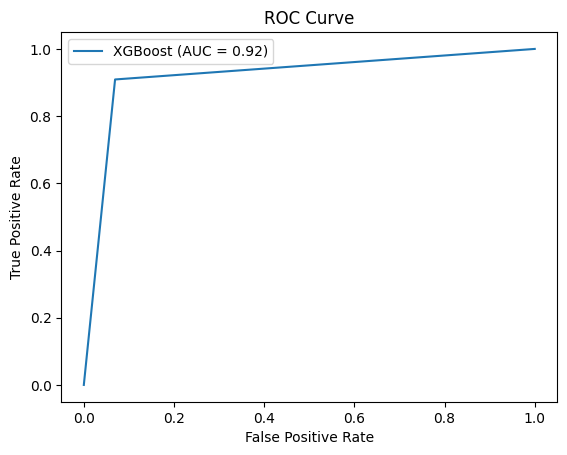

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
y_pred_prob = y_pred
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [33]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]}

xgb_clf = XGBClassifier(objective='binary:logistic')
grid = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy',verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Get the best parameters
best_params = grid.best_params_


# Fit model with best parameters
best_xgb_model = grid.best_estimator_

Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}


## Feature Importance

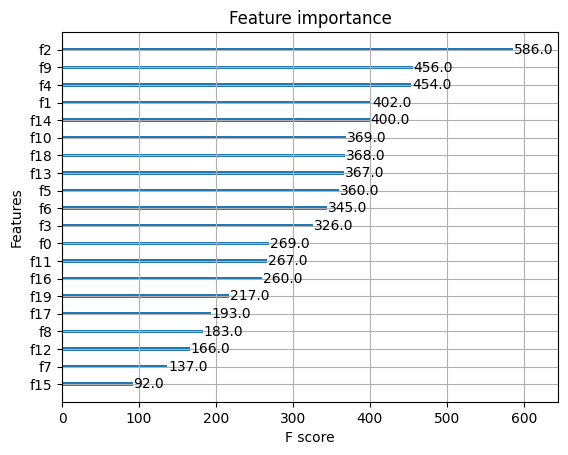

In [36]:
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()


In [34]:
y_pred_final = best_xgb_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f'Final Model Accuracy: {accuracy_final}') 

Final Model Accuracy: 0.925
